In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import sklearn as skl
from sklearn import preprocessing
from sklearn import model_selection
import matplotlib.pyplot as plt
from pickle import dump, load

from training_functions import summarize_data, get_encoded_labels_overshoot_undershoot_classification

In [2]:
# Load data
dataset = pd.read_csv("../Datasets/Three Coefficient 2nd Order/Three Coefficient System Data Balanced.csv")
print(dataset.head())
summarize_data(dataset)

         N1         D2         D1  RiseTime  TransientTime  SettlingTime  \
0 -2.098997   9.355879  12.169613  1.418254       2.808480      3.004993   
1 -8.064675   7.424314  10.984939  1.178159       2.236274      2.261321   
2  3.355627  10.362653  17.972740  0.690566       1.434136      1.434136   
3 -5.016306   6.777631  10.215730  1.109049       2.153838      2.198836   
4 -6.944586   7.414111  13.427289  0.904405       1.722170      1.748116   

   SettlingMin  SettlingMax  Overshoot  Undershoot      Peak  PeakTime  
0    -0.172400    -0.155525        0.0   35.908827  0.172400  5.423694  
1    -0.733804    -0.660804        0.0    5.243774  0.733804  4.088517  
2     0.168055     0.186666        0.0   -0.000000  0.186666  3.487674  
3    -0.490662    -0.442658        0.0   10.675850  0.490662  3.643252  
4    -0.516743    -0.465671        0.0    8.085863  0.516743  2.766764  
Models with overshoot: 3334/33.339999999999996%
Models with undershoot: 3334/33.339999999999996%
Models w

In [3]:
# Determine the appropriate label for each entry using one-hot encoding
# [0 0 1] for undershoot, [0 1 0] for overshoot, [1 0 0] for neither
labels = get_encoded_labels_overshoot_undershoot_classification(dataset)
print(labels[0:10])

[[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [4]:
# Convert to numpy array
data_array = dataset.to_numpy()

# Separate the coefficients, which form the inputs to the neural network, from the rest of the data
# The coefficients are the first columns in the CSV file
coefficients = data_array[:,0:3]
# Use StandardScaler to remove the mean and scale to unit variance
scaler = preprocessing.StandardScaler().fit(coefficients)
scaled_coefficients = scaler.transform(coefficients)

print(scaled_coefficients[0:10,:])
print(scaled_coefficients.shape)

[[-5.95626000e-01 -2.68288939e-01 -6.77002867e-01]
 [-1.72480106e+00 -7.39706047e-01 -7.29012032e-01]
 [ 4.36817712e-01 -2.25757537e-02 -4.22235882e-01]
 [-1.14781006e+00 -8.97535451e-01 -7.62781617e-01]
 [-1.51279213e+00 -7.42196203e-01 -6.21788768e-01]
 [-1.93462792e+00 -3.10796381e-01 -2.86181310e-01]
 [ 1.67465429e+00  1.20770173e-01 -3.81615496e-01]
 [-2.15755976e-01  5.40873743e-01  2.19079969e-01]
 [ 1.57360915e+00 -1.22635319e+00 -1.03992242e+00]
 [-6.33407146e-01  2.43423483e-01  1.15969363e-03]]
(10000, 3)


In [5]:
# Reserve 10% of the data as test data, and use the rest as training data
train_inputs,test_inputs,train_labels,test_labels = model_selection.train_test_split(scaled_coefficients, labels, test_size=0.10)
print(train_inputs.shape, train_labels.shape,test_inputs.shape, test_labels.shape)

(9000, 3) (9000, 3) (1000, 3) (1000, 3)


In [6]:
# Use a sequential model for classification
model = tf.keras.models.Sequential()
# First hidden layer: 128 nodes, RELU activation function
model.add(keras.layers.Dense(128,
                             input_shape=(3,),
                              name='layer_1',
                              activation='relu'))
# Second hidden layer: 128 nodes, RELU activation function
model.add(keras.layers.Dense(128,
                              name='layer_2',
                              activation='relu'))
# Output layer: softmax activation function
model.add(keras.layers.Dense(3,
                             name='output_layer',
                             activation='softmax'))

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_1 (Dense)             (None, 128)               512       
                                                                 
 layer_2 (Dense)             (None, 128)               16512     
                                                                 
 output_layer (Dense)        (None, 3)                 387       
                                                                 
Total params: 17,411
Trainable params: 17,411
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
450/450 [==============================] - 1s 1ms/step - loss: 0.2622 - accuracy: 0.9140 - val_loss: 0.1562 - val_accuracy: 0.9389
Epoch 2/10
450/450 [==============================] - 0s 1ms/step - loss: 0.1214 - accuracy: 0.9560 - val_loss: 0.1125 - val_accuracy: 0.9561
Epoch 3/10
450/450 [==============================] - 1s 1ms/step - loss: 0.1005 - accuracy: 0.9582 - val_loss: 0.0942 - val_accuracy: 0.9606
Epoch 4/10
450/450 [==============================] - 0s 940us/step - loss: 0.0892 - accuracy: 0.9646 - val_loss: 0.0766 - val_accuracy: 0.9683
Epoch 5/10
450/450 [==============================] - 0s 1ms/step - loss: 0.0850 - accuracy: 0.9656 - val_loss: 0.0786 - val_accuracy: 0.9689
Epoch 6/10
450/450 [==============================] - 0s 1ms/step - loss: 0.0801 - accuracy: 0.9694 - val_loss: 0.0897 - val_accuracy: 0.9644
Epoch 7/10
450/450 [==============================] - 0s 925us/step - loss: 0.0784 - accuracy: 0.9679 - val_loss: 0.0649 - val_accuracy: 0.9689
Ep

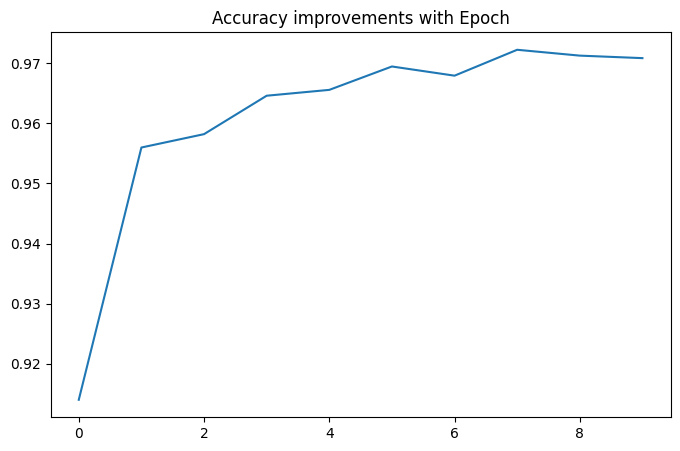


Evaluation against Test Dataset :
------------------------------------
32/32 [==============================] - 0s 684us/step - loss: 0.0885 - accuracy: 0.9610


[0.08846834301948547, 0.9610000252723694]

In [7]:
# Perform training

history=model.fit(train_inputs,
          train_labels,
          batch_size = 16,
          epochs = 10,
          verbose = 1,
          validation_split = 0.2)

# Code borrowed from Kumaran Ponnambalam's LinkedIn Learning course
# Check the accuracy after each epoch
pd.DataFrame(history.history)["accuracy"].plot(figsize=(8, 5))
plt.title("Accuracy improvements with Epoch")
plt.show()

#Evaluate the model against the test dataset and print results
print("\nEvaluation against Test Dataset :\n------------------------------------")
model.evaluate(test_inputs, test_labels)

In [8]:
# Export the model and the scaler used with the data
# Both will be stored in a directory matching the model name
model.save("OUID_3C_Basic/OUID_3C_Basic")
dump(scaler, open('OUID_3C_Basic/scaler.pkl','wb'))

INFO:tensorflow:Assets written to: OUID_3C_Basic/OUID_3C_Basic\assets


INFO:tensorflow:Assets written to: OUID_3C_Basic/OUID_3C_Basic\assets


In [7]:
# For testing existing models on new data
model = keras.models.load_model("OUID_3C_Optimized/OUID_3C_Optimized")
scaler = load(open('OUID_3C_Optimized/scaler.pkl','rb'))
dataset = pd.read_csv("../Datasets/Three Coefficient 2nd Order/Three Coefficient System Data 2.csv")
labels = get_encoded_labels_overshoot_undershoot_classification(dataset)
data_array = dataset.to_numpy()
scaled_input = scaler.transform(data_array[:,0:3])
raw_predictions = model.predict(scaled_input)
#print("Raw Prediction Output (Probabilities) :\n" , raw_predictions[0:10])
predictions = np.argmax(raw_predictions,1)
print(predictions)
actual = np.argmax(labels,1)
print(actual)

313/313 [==============================] - 0s 660us/step
[2 2 1 ... 2 2 2]
[2 2 1 ... 2 2 2]


In [8]:
# Analysis of the performance of the model
incorrect_indices = (predictions - actual).nonzero()
num_incorrect = incorrect_indices[0].shape[0]
print("Number of classification errors: " + str(num_incorrect))
print("Accuracy: " + str((dataset.shape[0] - num_incorrect)/dataset.shape[0]))
# Generate confusion matrix; rows correspond to actual label and columns correspond to predicted label
confusion_matrix = np.zeros((3,3))
for i in range(dataset.shape[0]):
    if actual[i] == 0 and predictions[i] == 0:
        confusion_matrix[0,0] = confusion_matrix[0,0] + 1
    elif actual[i] == 1 and predictions[i] == 0:
        confusion_matrix[1,0] = confusion_matrix[1,0] + 1
    elif actual[i] == 2 and predictions[i] == 0:
        confusion_matrix[2,0] = confusion_matrix[2,0] + 1
    elif actual[i] == 0 and predictions[i] == 1:
        confusion_matrix[0,1] = confusion_matrix[0,1] + 1
    elif actual[i] == 1 and predictions[i] == 1:
        confusion_matrix[1,1] = confusion_matrix[1,1] + 1
    elif actual[i] == 2 and predictions[i] == 1:
        confusion_matrix[2,1] = confusion_matrix[2,1] + 1
    elif actual[i] == 0 and predictions[i] == 2:
        confusion_matrix[0,2] = confusion_matrix[0,2] + 1
    elif actual[i] == 1 and predictions[i] == 2:
        confusion_matrix[1,2] = confusion_matrix[1,2] + 1
    elif actual[i] == 2 and predictions[i] == 2:
        confusion_matrix[2,2] = confusion_matrix[2,2] + 1
print(confusion_matrix)

Number of classification errors: 241
Accuracy: 0.9759
[[3432.   11.  128.]
 [  41. 1470.   12.]
 [   0.   49. 4857.]]


Optimizing the hyperparameters
Run at least cells 1 through 5 before running these

In [6]:
# Compare different options for number of hidden layers and nodes per layer (keeping the nodes per layer uniform)
num_layer_options = [2, 3, 4]
nodes_per_layer_options = [64, 128, 256]
indx_1 = indx_2 = 0
model_histories = []
accuracy_measures = [[0 for j in range(len(num_layer_options))] for i in range(len(nodes_per_layer_options))]
models = [[0 for j in range(len(num_layer_options))] for i in range(len(nodes_per_layer_options))]
for nlo in num_layer_options:
    model_histories.append([])
    for nplo in nodes_per_layer_options:
        
        model = tf.keras.models.Sequential()
        model.add(keras.layers.Dense(nplo,
                                        input_shape=(3,),
                                        name='1',
                                        activation='relu'))
        for i in range(nlo-1):
            model.add(keras.layers.Dense(nplo,
                                        name=str(i+2),
                                        activation='relu'))
        model.add(keras.layers.Dense(3,
                                    name='output_layer',
                                    activation='softmax'))

        model.compile(loss='categorical_crossentropy',
                    metrics=['accuracy'])
        accuracy_measures[indx_1][indx_2] = model.fit(train_inputs,train_labels,batch_size = 16,epochs = 10,verbose = 0,validation_split = 0.2).history["accuracy"]
        models[indx_1][indx_2] = model
        indx_2 = indx_2 + 1
    indx_1 = indx_1 + 1
    indx_2 = 0


In [7]:
# Load a separate dataset for testing
test_dataset = pd.read_csv("../Datasets/Three Coefficient 2nd Order/Three Coefficient System Data Balanced 2.csv")
labels = get_encoded_labels_overshoot_undershoot_classification(test_dataset)
data_array = test_dataset.to_numpy()
scaled_input = scaler.transform(data_array[:,0:3])

plt.figure(figsize=(15, 8))
for i in range(len(num_layer_options)):
    for j in range(len(nodes_per_layer_options)):
        #plt.plot(accuracy_measures[i][j], label = str(num_layer_options[i]) + "/" + str(nodes_per_layer_options[j]))

        #Evaluate the model against the test dataset and print results
        print("\nEvaluation against Test Dataset :\n------------------------------------")
        models[i][j].evaluate(scaled_input, labels)

# plt.title("Comparison of Validation Accuracy")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.show()


Evaluation against Test Dataset :
------------------------------------
3125/3125 [==============================] - 2s 757us/step - loss: 0.0674 - accuracy: 0.9717

Evaluation against Test Dataset :
------------------------------------
3125/3125 [==============================] - 2s 759us/step - loss: 0.0686 - accuracy: 0.9699

Evaluation against Test Dataset :
------------------------------------
3125/3125 [==============================] - 3s 837us/step - loss: 0.1239 - accuracy: 0.9589

Evaluation against Test Dataset :
------------------------------------
3125/3125 [==============================] - 2s 749us/step - loss: 0.0753 - accuracy: 0.9662

Evaluation against Test Dataset :
------------------------------------
3125/3125 [==============================] - 2s 756us/step - loss: 0.0711 - accuracy: 0.9714

Evaluation against Test Dataset :
------------------------------------
3125/3125 [==============================] - 3s 901us/step - loss: 0.1356 - accuracy: 0.9529

Evaluatio

<Figure size 1500x800 with 0 Axes>

The best performance in terms of accuracy came from using 4 layers and 128 nodes per layer in my testing; note that the performance will vary

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_1 (Dense)             (None, 128)               512       
                                                                 
 layer_2 (Dense)             (None, 128)               16512     
                                                                 
 layer_3 (Dense)             (None, 128)               16512     
                                                                 
 layer_4 (Dense)             (None, 128)               16512     
                                                                 
 output_layer (Dense)        (None, 3)                 387       
                                                                 
Total params: 50,435
Trainable params: 50,435
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
450/450 [==============================] 

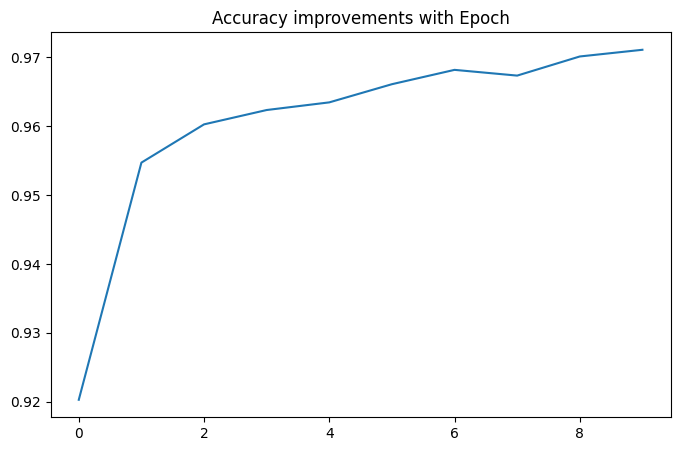


Evaluation against Test Dataset :
------------------------------------
32/32 [==============================] - 0s 959us/step - loss: 0.0738 - accuracy: 0.9720


INFO:tensorflow:Assets written to: OUID_3C_Optimized/OUID_3C_Optimized\assets


INFO:tensorflow:Assets written to: OUID_3C_Optimized/OUID_3C_Optimized\assets


In [6]:
# Use a sequential model for classification
model = tf.keras.models.Sequential()
# First hidden layer: 128 nodes, RELU activation function
model.add(keras.layers.Dense(128,
                             input_shape=(3,),
                              name='layer_1',
                              activation='relu'))
# Second hidden layer: 128 nodes, RELU activation function
model.add(keras.layers.Dense(128,
                              name='layer_2',
                              activation='relu'))
model.add(keras.layers.Dense(128,
                              name='layer_3',
                              activation='relu'))
model.add(keras.layers.Dense(128,
                              name='layer_4',
                              activation='relu'))
# Output layer: softmax activation function
model.add(keras.layers.Dense(3,
                             name='output_layer',
                             activation='softmax'))

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()
# Perform training

history=model.fit(train_inputs,
          train_labels,
          batch_size = 16,
          epochs = 10,
          verbose = 1,
          validation_split = 0.2)

# Code borrowed from Kumaran Ponnambalam's LinkedIn Learning course
# Check the accuracy after each epoch
pd.DataFrame(history.history)["accuracy"].plot(figsize=(8, 5))
plt.title("Accuracy improvements with Epoch")
plt.show()

#Evaluate the model against the test dataset and print results
print("\nEvaluation against Test Dataset :\n------------------------------------")
model.evaluate(test_inputs, test_labels)
model.save("OUID_3C_Optimized/OUID_3C_Optimized")
dump(scaler, open('OUID_3C_Optimized/scaler.pkl','wb'))